In [1]:
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors
from gensim import downloader
import gzip 
import math
import itertools
from time import time
from tqdm import tqdm
import tqdm.notebook as tq
import os
import pandas as pd
import json
import gensim.downloader as api
import numpy as np
import vec_tools
from scipy.stats import pearsonr

# Embedding evaluation (now in vec_tools)

In [2]:
class EvalEmbeddings():
    # self.evals to access evaluation scores
    def __init__(self, dir, files, kv, dl=False):
        self.fils = files
        self.dl = dl
        #Change directory
        os.chdir(dir)
        self.models = {}
        self.evals = {}
        self.kv = kv

    def load_wv(self, fil):
        #True for external models that need downloading
        if self.dl == False:
            #For if model stored in KeyedVectors format
            if self.kv == True:
                wv = KeyedVectors.load(fil)
                self.models[fil] = wv
                return wv
            #Normal word2vec format
            elif os.path.isfile(fil):
                model = gensim.models.Word2Vec.load(fil)
                self.models[fil] = model.wv
                return model.wv
            else: 
                print(f"{fil} embeddings do not exist!")
                return 0
        else: 
            print("Loading", fil, "...")
            model = api.load(fil)
            self.models[fil] = model
            print("Loading finished.")
            return model
    def save(self, fname):
        self.df = pd.DataFrame(self.evals)
        self.df.to_csv("G:/My Drive/KU/Thesis/outputs/evals/" + fname)
        
    def iterate(self, kv=False):
        for fil in self.fils:
            wv = self.load_wv(fil)
            if wv == 0: #load_wv returns wv if embeddings don't exist
                continue
            else: #create dic for decade
                self.eval_embed(fil)
        self.evals_df = pd.DataFrame(self.evals)
               
    def eval_embed(self, fil):
        self.evals[fil] = {}
        print(f"\n*****Starting evaluation for {fil}*****")
        
        # Evaluate one set of embeddings (for one decade) - scores stored under "analogy_score", and "word_pair_pearson/spearman"
        print("Starting analogy evaluation...")
        analog = self.models[fil].evaluate_word_analogies('C:/ProgramData/Anaconda3/Lib/site-packages/gensim/test/test_data/questions-words.txt')
        self.evals[fil]["analogy_score"] = analog[0]
        
        print("Starting word pair similarity evaluation...")
        #Evaluating similarity of word pairs compared with human assigned scores, check goldberg notes for other datasets
        word_pairs = self.models[fil].evaluate_word_pairs('C:/ProgramData/Anaconda3/Lib/site-packages/gensim/test/test_data/wordsim353.tsv')
        self.evals[fil]["word_pair_pearson"]= word_pairs[0][0]#tuple with correlation score & 2-tailed p-value
        self.evals[fil]["word_pair_pearson_p_value"]  = word_pairs[0][1]
        
        self.evals[fil]["word_pair_spearman"]= word_pairs[1][0]
        self.evals[fil]["word_pair_spearman_p_value"] = word_pairs[1][1]
        
        #Evaluating against surveys
        print("Starting survey evaluation...")
        self.evals[fil] =  self.evals[fil] | self.corr_survey(fil)
        
        print(f"{fil} embeddings evaluated.\n")
    
    def create_dim(self, model, df):
        dims = []
        for row in df.iterrows():
            cols = df.columns
            pos = self.models[model].get_vector(cols[0], norm=True)
            neg = self.models[model].get_vector(cols[1], norm=True)
            dim = pos - neg
            dims.append(dim)
        final_dim = np.mean(np.array(dims), axis = 0)
        return final_dim

    def proj_dim(self, model, dim):
        embed = self.models[model].get_normed_vectors()
        proj = np.dot(embed, dim)
        return proj
    
    def corr_gss(self, model):
        survey = pd.read_csv(f"G:/My Drive/KU/Thesis/data/survey_data/gss_averages.csv", index_col = "capital")
        music_genres_conv = {"bigband": "big-band","blugrass": "bluegrass", "country": "country", "blues": "blues", "musicals": "musicals", "classicl": "classical", "folk": "folk", "gospel": "gospel", "jazz": "jazz", "latin": ["salsa", "samba", "bachata", "kilomba", "tango", "rumba", "bolero"], "moodeasy": "easy-listening", "newage": ["new-age", "newage"], "opera": "opera", "rap": "rap", "reggae": "reggae", "conrock": "rock", "oldies": "oldies", "hvymetal": "heavy-metal"}
        music_genres_conv = {"bigband": "big-band","blugrass": "bluegrass", "country": "country", "blues": "blues", "musicals": "musicals", "classicl": "classical", "folk": "folk", "gospel": "gospel", "jazz": "jazz", "latin": "salsa", "moodeasy": "easy-listening", "newage": "new-age", "opera": "opera", "rap": "rap", "reggae": "reggae", "conrock": "rock", "oldies": "oldies", "hvymetal": "heavy-metal"}
        music_genres = {v: k for k, v  in music_genres_conv.items()}
        activities_conv = {"attsprts":"sports", "visitart":"art", "makeart":"art", "autorace":"autosport", "camping":"camping", "garden":"gardening", "dance":["dancing","dance"], "gomusic":["concert", "gig"],"huntfish":["hunting","fishing"], "perform":[], "dosports":["sports", "sport"], "seemovie":[], "usevcr":[], "plymusic":[], "readfict":"reading", "popmusic":"pop", "drama":[], "relart":[], "volarts":[]}
        activities_conv = {"attsprts":"sports", "visitart":"art", "makeart":"art", "autorace":"autosport", "camping":"camping", "garden":"gardening", "dance":"dancing", "gomusic":"concert","huntfish":"fishing", "dosports":"sports", "seemovie":[], "usevcr":[], "plymusic":[], "readfict":"reading", "popmusic":"pop", "drama":[], "relart":[], "volarts":[]}
        activities = {v: k for k, v in activities_conv.items() if type(v) != list}
        capitals = {"educ":"education", "prestg80":"status", "rincome":"affluence"}#, "class":"affluence"}#, "class"]
        cats = capitals.values()
        capitals = {v: k for k, v in capitals.items()}
        domains = {"music":music_genres_conv, "activities": activities_conv}

        
        vals = {domain: {} for domain in domains.keys()}
        self.vals = {}
        ant_pairs = {}
        projs = {}
        dims = {}
        embed = self.models[model]
        print(survey.columns)
        for domain, dic in domains.items():
            for cat in cats:
                ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
                ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
                #prepare dictionaries for survey & projection values
                vals[domain][cat + "_survey"] = {}
                vals[domain][cat + "_proj"] = {}
                #calculate dimensions from antonym pairs
                dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
                #project embeddings onto dimension
                projs[cat] = self.proj_dim(model, dims[cat])
                #iterate through words
                not_in_vocab = []
                for index, row in survey.iterrows():
                    #print(row.name)
                    try:
                        word = dic[row.name].lower()
                        #print(word)
                        #retrieve index in embeddings
                        ind = embed.get_index(word)
                        #retrieve projected value using index
                        val = projs[cat][ind]
                        #add all to DF
                        vals[domain][cat + "_survey"][word] = row[capitals[cat] + "_mean"]
                        vals[domain][cat + "_proj"][word] = val
                    except Exception as e:
                        pass
                       # print(e)
                        #not_in_vocab.append(word)

                #print(f"{not_in_vocab} not in embeddings vocab!")
            self.vals[domain] = pd.DataFrame(vals[domain])
        corrs = {}
        for domain in domains.keys():
            for cat in cats:
          #  print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
                corrs[domain + "_" + cat + "_survey_corr"] = pearsonr(self.vals[domain][cat + "_survey"], self.vals[domain][cat + "_proj"])
            #corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
        
    def corr_gbcs(self, model):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/gbcs_averages.csv", index_col = 0)
        activities_conv = {"carts":"gallery", "cbingo":"bingo", "csportw":"sport", "ctheatre":"theatre", 
                "copera":"opera", "cdance":"dance","cmags":"magazine", "cdiy":"diy", 
                "pub":"pub", "cclassic":"classical", "cshopping":"shopping", "cresta":"restaurant",
                "ctv":["tv", "television"], "cbooks":"reading", "cgig":"gig"}
        music_conv = {"mreggae":"reggae", "mjazz":"jazz", "mpop":"pop", "mfolk":"folk",
             "mclassic":"classical"}#, "mrock":"rock", "mcountry":"country" "mmetal":"metal","
        domains = {"activities":activities_conv, "music": music_conv}                                   
        activities = {v: k for k, v in activities_conv.items() if type(v) != list}
        capitals = {"hhincome": "affluence", "educ":"education", "chigh":"cultivation"}
        music_genres = {v: k for k, v  in music_conv.items()}
        cats = capitals.values()
        capitals = {v: k for k, v in capitals.items()}

        ant_pairs = {}
        vals = {domain: {} for domain in domains.keys()}
        projs = {}
        dims = {}
        embed = self.models[model]
        self.vals = {}

        for domain, dic in domains.items():
            for cat in cats:
                #print(domain, cat)
                ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
                ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
                #prepare dictionaries for survey & projection values
                vals[domain][cat + "_survey"] = {}
                vals[domain][cat + "_proj"] = {}
                #calculate dimensions from antonym pairs
                dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
                #project embeddings onto dimension
                projs[cat] = self.proj_dim(model, dims[cat])
                #iterate through words
                not_in_vocab = []
                for index, row in survey.iterrows():
                    #print(index, row)
                    try:
                        word = dic[row.name].lower()
                        #print(word)
                        #retrieve index in embeddings
                        ind = embed.get_index(word)
                        #retrieve projected value using index
                        val = projs[cat][ind]
                        #add all to DF
                        vals[domain][cat + "_survey"][word] = row[capitals[cat] + "_mean"]
                        vals[domain][cat + "_proj"][word] = val
                    except Exception as e:
                        pass
                        #not_in_vocab.append(word)

             #   print(f"{not_in_vocab} not in embeddings vocab!")
            self.vals[domain] = pd.DataFrame(vals[domain])
        corrs = {}
        for domain, dic in domains.items():
            for cat in cats:
               # print(self.vals[domain][cat + "_survey"], self.vals[domain][cat + "_proj"])
                corrs[domain + "_" + cat + "_survey_corr"] = pearsonr(self.vals[domain][cat + "_survey"], self.vals[domain][cat + "_proj"])
                #corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
    
          
    def corr_census(self, model, labels="words", outliers=[]):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/us_census/census_1990_OCC1950.csv", index_col = 0)
        occ_map = pd.read_csv("G:/My Drive/KU/Thesis/data/garg/occupation_map.csv", index_col="Occupation, 1950 basis").to_dict()["Single words"]
                           
        occs = {v: k for k, v in occ_map.items() if type(v) != list}
        capitals = {"EDUC":"Cultivation", "PRESGL":"Status", "INCTOT":"Affluence"}
        cats = capitals.values()
        capitals = {v: k for k, v in capitals.items()}

        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        embed = self.models[model]
        self.vals = {}

        for cat in cats:
            #print(domain, cat)
            ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
            ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
            #prepare dictionaries for survey & projection values
            vals[cat + "_survey"] = {}
            vals[cat + "_proj"] = {}
            #calculate dimensions from antonym pairs
            dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
            #project embeddings onto dimension
            projs[cat] = self.proj_dim(model, dims[cat])
            #iterate through words
            not_in_vocab = []
            nan = False
            for index, row in survey.iterrows():
                #print(index, row)
                try:
                    if row.name in outliers:
                        continue
                    #print( occ_map[row.name])
                    occ_spl = occ_map[row.name].lower().split()
                #    print(occ_spl)
                    w_projs = []
                    for w in occ_spl:
                        if w == "nan":
                            continue
                        if w[-1] == ",":
                            w = w[:-1]
                        try:
                            ind = embed.get_index(w)
                            proj = projs[cat][ind]
                        except: 
                            continue
                        if proj != proj:
                            continue
                        w_projs.append(proj)
                    #    print(row.name, w_projs)
                        val = np.mean(w_projs)
                        #add all to DF
                        if labels == "words":
                            label =  occ_map[row.name].title()
                        else:
                            label =  row.name
                        vals[cat + "_survey"][label] = row[capitals[cat] + "_mean"]
                        vals[cat + "_proj"][label] = val
                except Exception as e:
                    pass
                    #print(e)
                    #not_in_vocab.append(word)

         #   print(f"{not_in_vocab} not in embeddings vocab!")
        self.vals = pd.DataFrame(vals)
        corrs = {}
        for cat in cats:
           # print(self.vals[domain][cat + "_survey"], self.vals[domain][cat + "_proj"])
           # print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
            corrs[cat + "_survey_corr"] = pearsonr(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
            #corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
                        
    def corr_survey(self, model):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/survey_means_weighted.csv")
        survey = survey.rename(columns= {"Unnamed: 0": "words"})
        survey = survey.set_index("words")
        cats =  ["race", "gender", "affluence"]

        
        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        embed = self.models[model]

        for cat in cats:
            ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
            ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
            #prepare dictionaries for survey & projection values
            vals[cat + "_survey"] = {}
            vals[cat + "_proj"] = {}
            #calculate dimensions from antonym pairs
            dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
            #project embeddings onto dimension
            projs[cat] = self.proj_dim(model, dims[cat])
            #iterate through words
            not_in_vocab = []
            for row in survey.iterrows():
                word = row[0].lower()
                try:
                    #print(word)
                    #retrieve index in embeddings
                    ind = embed.get_index(word)
                    #retrieve projected value using index
                    val = projs[cat][ind]
                    #add all to DF
                    vals[cat + "_survey"][word] = row[1][cat + "_mean"]
                    vals[cat + "_proj"][word] = val
                except Exception as e:
                    not_in_vocab.append(word)
                    
          #  print(f"{not_in_vocab} not in embeddings vocab!")
        self.vals = pd.DataFrame(vals)
        corrs = {}
        for cat in ["race", "gender", "affluence"]:
            print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
            corrs[cat + "_survey_corr"] = pearsonr(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
           # corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs

In [4]:
coll ="histwords_engall"# "gb_12_18_02"# 
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_coha = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = "word2vec-google-news-300", kv=True, dl=False)
eval_coha.load_wv(decade_files[-1])
#eval_coha.load_wv('word2vec-google-news-300')
#print(eval_coha.corr_gss(decade_files[-1]))
#print(eval_coha.corr_gbcs(decade_files[-1]))
outliers_aff = ["Dancers and dancing teachers", "Musicians and music teachers", "Designers", 
 "Painters, except construction or maintenance", "Authors", "Artists and art teachers",
"Photographers", "Dentists", "Physicians and surgeons", "Policemen and detectives", "Sports instructors and officials",
           "Lawyers and judges", "Airplane pilots and navigators", "Vetinarians", #more questionable second round
            "Stock and bond salesman","Sailors and deck hands"]
outliers_status = ["Members of the armed services", "Tool makers, and die makers, and setters", "Painters, except construction and maintenance"]
#print(eval_coha.corr_census(decade_files[-1], labels="words", outliers=[]))
#print(eval_coha.corr_census(decade_files[-1], labels="words", outliers= [], table=True))

In [7]:
print(pd.DataFrame({"ENG\_ALL":{'Education': '0.524***','Cultivation': '0.21', 'Status': '0.518***', 'Affluence': '0.011'}, "Google News": {'Education': '0.562***','Cultivation': '0.001', 'Status': '0.493***', 'Affluence': '0.013'} }).to_latex())

\begin{tabular}{lll}
\toprule
{} &  ENG\textbackslash \_ALL & Google News \\
\midrule
Education   &  0.524*** &    0.562*** \\
Cultivation &      0.21 &       0.001 \\
Status      &  0.518*** &    0.493*** \\
Affluence   &     0.011 &       0.013 \\
\bottomrule
\end{tabular}



In [6]:
print(eval_coha.corr_census(decade_files[-1], labels="words", outliers= outliers_aff, table=True))
#print(pd.DataFrame(eval_coha.corr_gss('word2vec-google-news-300', table=True)).to_latex())
#print(pd.DataFrame(eval_coha.corr_gbcs('word2vec-google-news-300', table=True)).to_latex())

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


{'Education': '0.562***', 'Status': '0.591***', 'Affluence': '0.379**'}


G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cultivation_survey', ylabel='Cultivation_proj'>

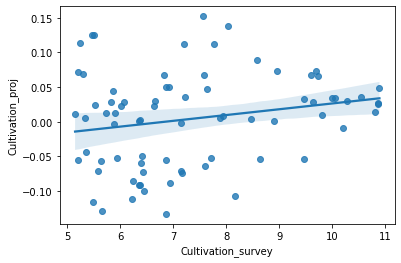

In [187]:
import seaborn as sns
#print(eval_coha.vals)
dim = "Cultivation"
sns.regplot(eval_coha.vals[f"{dim}_survey"],eval_coha.vals[f"{dim}_proj"])
#sns.regplot(eval_coha.vals["activities"]["affluence_survey"],eval_coha.vals["activities"]["affluence_proj"])
#eval_coha.vals["music"].plot.scatter(x="affluence_survey",y="affluence_proj")

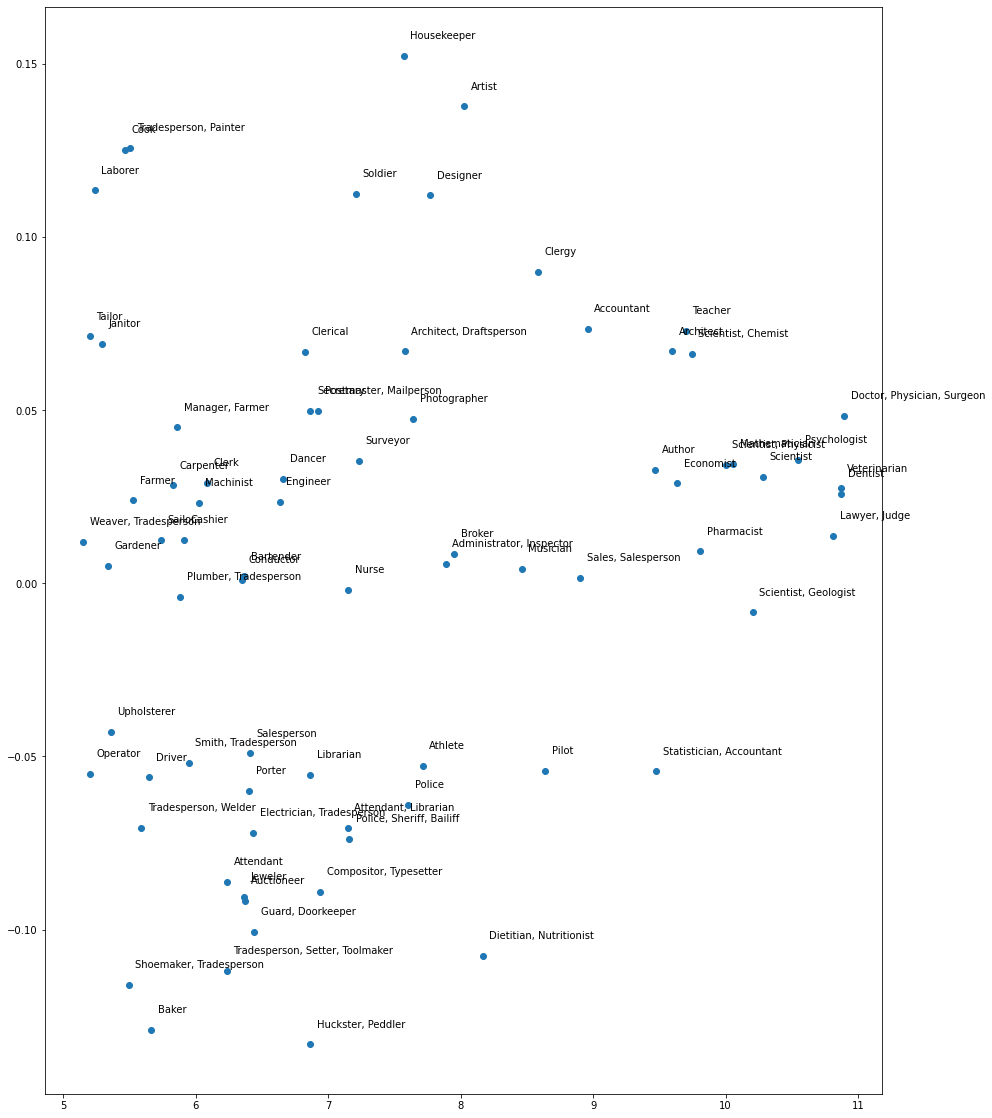

In [188]:

from matplotlib import pyplot as plt
fig,ax = plt.subplots(figsize=(15,20))
surv = eval_coha.vals[f'{dim}_survey']
proj = eval_coha.vals[f'{dim}_proj']
#sns.scatterplot(data=eval_coha.vals,x='Affluence_survey', y="Affluence_proj")
plt.scatter(surv, proj)
# Annotate label points 
drift = (0.05,0.005)#status(1, 0.005)#aff(50, 0.005) 
for i, occ in enumerate (eval_coha.vals.index):
    plt.annotate(occ, (surv[i]+drift[0], proj[i]+drift[1]) )
#eval_coha.vals.plot.scatter(x="Affluence_survey",y="Affluence_proj")


In [8]:
def corr_survey(self, model):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/survey_means_weighted.csv")
        survey = survey.rename(columns= {"Unnamed: 0": "words"})
        survey = survey.set_index("words")
        cats =  ["race", "gender", "affluence"]

        
        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        embed = self.models[model]

        for cat in cats:
            ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
            ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
            #prepare dictionaries for survey & projection values
            vals[cat + "_survey"] = {}
            vals[cat + "_proj"] = {}
            #calculate dimensions from antonym pairs
            dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
            #project embeddings onto dimension
            projs[cat] = self.proj_dim(model, dims[cat])
            #iterate through words
            not_in_vocab = []
            for row in survey.iterrows():
                word = row[0].lower()
                try:
                    #print(word)
                    #retrieve index in embeddings
                    ind = embed.get_index(word)
                    #retrieve projected value using index
                    val = projs[cat][ind]
                    #add all to DF
                    vals[cat + "_survey"][word] = row[1][cat + "_mean"]
                    vals[cat + "_proj"][word] = val
                except Exception as e:
                    not_in_vocab.append(word)
                    
          #  print(f"{not_in_vocab} not in embeddings vocab!")
        self.vals = pd.DataFrame(vals)
        corrs = {}
        for cat in ["race", "gender", "affluence"]:
           # print(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
            corrs[cat + "_survey_corr"] = pearsonr(self.vals[cat + "_survey"], self.vals[cat + "_proj"])
           # corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
corr_survey(eval_coha, decade_files[-1])

{'race_survey_corr': (-0.03909039755581012, 0.7832104721268501),
 'gender_survey_corr': (0.3765298113002713, 0.005936931097356145),
 'affluence_survey_corr': (0.25215548892027245, 0.07132828513226903)}

In [118]:
activities_conv = {"carts":"gallery", "cbingo":"bingo", "csportw":"sport", "ctheatre":"theatre", 
                "copera":"opera", "cdance":"dance","cmags":"magazine", "cdiy":"diy", 
                "pub":"pub", "cclassic":"classical", "cshopping":"shopping", "cresta":"restaurant",
                "ctv":["tv", "television"], "cbooks":"reading", "cgig":"gig"}
music_conv = {"mreggae":"reggae", "mjazz":"jazz", "mpop":"pop", "mfolk":"folk",
 "mclassic":"classical"}#
music_genres_conv = {"bigband": "big-band","blugrass": "bluegrass", "country": "country", "blues": "blues", "musicals": "musicals", "classicl": "classical", "folk": "folk", "gospel": "gospel", "jazz": "jazz", "latin": "salsa", "moodeasy": "easy-listening", "newage": "new-age", "opera": "opera", "rap": "rap", "reggae": "reggae", "conrock": "rock", "oldies": "oldies", "hvymetal": "heavy-metal"}
activities_conv2 = {"attsprts":"sports", "visitart":"art", "makeart":"art", "autorace":"autosport", "camping":"camping", "garden":"gardening", "dance":["dancing","dance"], "gomusic":["concert", "gig"],"huntfish":["hunting","fishing"], "perform":[], "dosports":["sports", "sport"], "seemovie":[], "usevcr":[], "plymusic":[], "readfict":"reading", "popmusic":"pop", "drama":[], "relart":[], "volarts":[]}
activities = list(activities_conv.values()) + list( activities_conv2.values())
music = list(music_conv.values()) + list(music_genres_conv.values())
print(activities)

['gallery', 'bingo', 'sport', 'theatre', 'opera', 'dance', 'magazine', 'diy', 'pub', 'classical', 'shopping', 'restaurant', ['tv', 'television'], 'reading', 'gig', 'sports', 'art', 'art', 'autosport', 'camping', 'gardening', ['dancing', 'dance'], ['concert', 'gig'], ['hunting', 'fishing'], [], ['sports', 'sport'], [], [], [], 'reading', 'pop', [], [], []]


In [115]:
coll = "gb_12_18_02"
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_coha = EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=False, dl=False)
eval_coha.load_wv(decade_files[-1])
print(eval_coha.corr_gss(decade_files[-1]))
print(eval_coha.corr_gbcs(decade_files[-1]))

Index(['educ_median', 'prestg80_median', 'rincome_median', 'wealth_median',
       'class_median', 'educ_mean', 'prestg80_mean', 'rincome_mean',
       'wealth_mean', 'class_mean'],
      dtype='object')
{'music_education_survey_corr': (-0.4704100879718365, 0.12274705449836597), 'music_status_survey_corr': (0.5170050581031205, 0.0852069683461182), 'music_affluence_survey_corr': (0.24182110806079093, 0.44891897835547495), 'activities_education_survey_corr': (0.30346960778953824, 0.42727774078417025), 'activities_status_survey_corr': (0.25578497512259485, 0.5064994186887669), 'activities_affluence_survey_corr': (0.4555631645687427, 0.21782974170207797)}
{'activities_affluence_survey_corr': (-0.0013852816734992446, 0.9965909171043603), 'activities_education_survey_corr': (0.31849348074842293, 0.31299630267688955), 'activities_cultivation_survey_corr': (-0.11148283470729677, 0.7301435129355796), 'music_affluence_survey_corr': (0.30331830331422555, 0.6198094898769204), 'music_education_surv

In [54]:
eval_coha.vals["music"]

,affluence_survey,affluence_proj,education_survey,education_proj,cultivation_survey,cultivation_proj
jazz,59094.851499,0.103744,5.513261,0.034377,15.369054,-0.038266
pop,57824.399136,0.031549,5.357274,0.011208,13.481764,0.004427
folk,54045.052363,-0.029350,5.548832,-0.004319,14.743503,-0.028985
classical,60853.583402,0.124678,5.578849,0.115145,15.901246,0.068317


# Evaluate histwords dataset

In [3]:
#COHA
coll = "histwords_engall"
#get filenames
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
#run evaluator
eval_coha = EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=True, dl=False)
eval_coha.iterate()
eval_coha.save(f"{coll}.csv")


*****Starting evaluation for 1900_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1900_model embeddings evaluated.


*****Starting evaluation for 1910_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1910_model embeddings evaluated.


*****Starting evaluation for 1920_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1920_model embeddings evaluated.


*****Starting evaluation for 1930_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1930_model embeddings evaluated.


*****Starting evaluation for 1940_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1940_model embeddings evaluated.


*****Starting evaluation for 1950_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1950_model embeddings evaluated.


*****Starting evaluation for 1960_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1960_model embeddings evaluated.


*****Starting evaluation for 1970_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1970_model embeddings evaluated.


*****Starting evaluation for 1980_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1980_model embeddings evaluated.


*****Starting evaluation for 1990_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]


Starting word pair similarity evaluation...
Starting survey evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
['hiphop', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah'] not in embeddings vocab!
1990_model embeddings evaluated.



In [4]:
for hword in ["D:/google_ngrams/Vectors/histwords_engfic/", "D:/google_ngrams/Vectors/histwords_engall/"]:
    eval_hist = EvalEmbeddings(dir = hword, files = decade_files, kv=True, dl=False)
    eval_hist.iterate()
    eval_hist.save(hword[-10:] + ".csv")


*****Starting evaluation for 1900_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1900_model embeddings evaluated.


*****Starting evaluation for 1910_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1910_model embeddings evaluated.


*****Starting evaluation for 1920_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1920_model embeddings evaluated.


*****Starting evaluation for 1930_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1930_model embeddings evaluated.


*****Starting evaluation for 1940_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1940_model embeddings evaluated.


*****Starting evaluation for 1950_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1950_model embeddings evaluated.


*****Starting evaluation for 1960_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1960_model embeddings evaluated.


*****Starting evaluation for 1970_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1970_model embeddings evaluated.


*****Starting evaluation for 1980_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1980_model embeddings evaluated.


*****Starting evaluation for 1990_model*****
Starting analogy evaluation...


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:441: RuntimeWarning: invalid value encountered in true_divide
  result = self.vectors[index] / self.norms[index]
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:783: RuntimeWarning: invalid value encountered in true_divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Starting word pair similarity evaluation...
Starting survey evaluation...


G:\My Drive\KU\Thesis\vec_tools.py:147: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]


['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1990_model embeddings evaluated.



OSError: [Errno 22] Invalid argument: 'G:/My Drive/KU/Thesis//outputs/evals/ds_engfic/.csv'

# Evaluate all decades

In [11]:
#get filenames
os.chdir("D:/google_ngrams/vectors/gb_12_18_02/")
decade_files = [str(1900+10*i)+ '_model' for i in range(10)]
#run evaluator
eval_gb_12 = EvalEmbeddings(dir = "D:/google_ngrams/vectors/gb_12_18_02/", files = decade_files, kv=False, dl=False)
eval_gb_12.iterate()
eval_gb_12.save("evals_gb_12_new.csv")


*****Starting evaluation for 1900_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'softball', 'volleyball', 'soccer', 'jazz', 'bluegrass', 'hiphop', 'techno', 'hamburger', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'jake', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'soccer', 'jazz', 'bluegrass', 'hiphop', 'techno', 'hamburger', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'jake', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'soccer', 'jazz', 'bluegrass', 'hiphop', 'techno', 'hamburger', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'jake', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
1900_model embeddings evaluated.


*****Starting evaluation for 1910_model*****
Starting analogy

In [12]:
os.chdir()
pd.read_csv("evals_gb_12_new.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'evals_gb_12_new.csv'

# Evaluate all years

In [18]:
#get filenames
year_files = ['vectors-'+str(1900+1*i)+'-ngram_model' for i in range(100)]
#run evaluator
eval_peryear = EvalEmbeddings(dir = "D:/google_ngrams/vectors/vectors_per_year_final/", files = year_files, kv=True, dl=False)
eval_peryear.iterate()


*****Starting evaluation for vectors-1900-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'baseball', 'softball', 'volleyball', 'hockey', 'soccer', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'baseball', 'softball', 'volleyball', 'hockey', 'soccer', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'baseball', 'softball', 'volleyball', 'hockey', 'soccer', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 

Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 's

Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'steak', 'pastry', 'motorcycle', 'minivan', 'skateboard', 'suv', 'tuxedo', 'briefcase', 'shorts', 'jake', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'steak', 'pastry', 'motorcycle', 'minivan', 'skateboard', 'suv', 'tuxedo', 'briefcase', 'shorts', 'jake', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'steak', 'pastry', 'motorcycle', 'mi


*****Starting evaluation for vectors-1923-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skat


*****Starting evaluation for vectors-1930-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shorts', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'mo


*****Starting evaluation for vectors-1937-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['basketball', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv


*****Starting evaluation for vectors-1944-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'pastry', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'pastry', 'motorcycle', 'minivan', 'skateboard', 'suv', 'limousine', 'tuxedo', 'briefcase', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['basketball', 'boxing', 'softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 

['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'nanny', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
vectors-1951-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-1952-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'jazz', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'motorcycle', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'


*****Starting evaluation for vectors-1960-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'hamburger', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
vectors-1960-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-19

vectors-1968-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-1969-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'soccer', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
vectors-1969-ngram_model embeddings evaluated.


*****Starting evaluation for v

['softball', 'volleyball', 'hockey', 'hairdresser', 'plumber', 'nanny', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'pastry', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
vectors-1977-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-1978-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hockey', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'tuxedo', 'shanice', 'aaliyah', 'jamal', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hipho

Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hockey', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['softball', 'volleyball', 'hockey', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
vectors-1987-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-1988-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'hairdresser', 'plumber', 'bluegrass', 'punk', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 

Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'bluegrass', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'bluegrass', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'tyrone'] not in embeddings vocab!
['softball', 'volleyball', 'bluegrass', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'tyrone'] not in embeddings vocab!
vectors-1998-ngram_model embeddings evaluated.


*****Starting evaluation for vectors-1999-ngram_model*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['softball', 'volleyball', 'bluegrass', 'hiphop', 'techno', 'cheesecake', 'minivan', 'skateboard', 'suv', 'shanice', 'aaliyah', 'jamal'] not in embeddings vocab!
['softball', 'volleyball', 'bluegrass', 'hiphop', 'techno', 'c

In [16]:
os.chdir("D:/google_ngrams/vectors/vectors_per_year/")
KeyedVectors.load("vectors_1900-ngram.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'vectors_1900-ngram.txt'

In [ ]:
pd.read_csv("evals_eng_fic.csv")

# Information on other baselines

In [ ]:
info = api.info()
for corpus_name, corpus_data in sorted(info['models'].items()):
    print(
        '%s (%d records): %s' % (
            corpus_name,
            corpus_data.get('num_records', -1),
            corpus_data['description'][:10] + '...',
        )
    )
corps = [corpus_name for corpus_name, corpus_data in sorted(info['models'].items())]
print(corps)

# Evaluate other baselines

In [12]:
external_models = ['conceptnet-numberbatch-17-06-300', 'fasttext-wiki-news-subwords-300', 'glove-twitter-100', 'glove-twitter-200', 'glove-twitter-25', 'glove-twitter-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-wiki-gigaword-50', 'word2vec-google-news-300'] #'__testing_word2vec-matrix-synopsis',  'word2vec-ruscorpora-300' 
       

external_eval = EvalEmbeddings(dir = "D:/google_ngrams/vectors/", files=external_models[1:], dl=True, kv=False)
external_eval.iterate()
#single
#external_eval.load_wv(external_models[4])
#external_eval.eval_embed(external_eval.models[external_models[4]], external_models[4])


Loading fasttext-wiki-news-subwords-300 ...
Loading finished.

*****Starting evaluation for fasttext-wiki-news-subwords-300*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
['shanice'] not in embeddings vocab!
['shanice'] not in embeddings vocab!
['shanice'] not in embeddings vocab!
fasttext-wiki-news-subwords-300 embeddings evaluated.

Loading glove-twitter-100 ...
Loading finished.

*****Starting evaluation for glove-twitter-100*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
[] not in embeddings vocab!
[] not in embeddings vocab!
[] not in embeddings vocab!
glove-twitter-100 embeddings evaluated.

Loading glove-twitter-200 ...
Loading finished.

*****Starting evaluation for glove-twitter-200*****
Starting analogy evaluation...
Starting word pair similarity evaluation...
Starting survey evaluation...
[] not in embeddings vocab!
[] not in embeddings vocab!
[] not 

In [8]:
mod = 'word2vec-google-news-300'
external_eval = vec_tools.EvalEmbeddings(dir = "D:/google_ngrams/vectors/", files=mod, dl=True, kv=False)
external_eval.load_wv(mod)
external_eval.corr_survey_grouped(mod)

Loading word2vec-google-news-300 ...


KeyboardInterrupt: 

# Collecting evaluations and turning into table format

In [10]:
evals = {}
evals["gb_12"] = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_gb_12_new.csv").round(3).T
evals["engfic"] = pd.read_csv("G:/My Drive/KU/Thesis//outputs/evals/evals_histwords_engfic.csv").round(3).T
evals["engall"] = pd.read_csv("G:/My Drive/KU/Thesis//outputs/evals/evals_histwords_engall.csv").round(3).T
evals["coha"] = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_histwords_coha.csv").round(3).T
external_evals = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_external_models.csv").round(3).T

agg_dfs = {}
for col in ['analogy_score','word_pair_pearson','race_survey_corr','gender_survey_corr','affluence_survey_corr']:
    i = 0
    for coll, df, in evals.items(): 
       # print(col, coll)
        if 'Unnamed: 0.1' in df.index:
            df = df.rename(columns=df.loc['Unnamed: 0.1']).drop(['Unnamed: 0', 'Unnamed: 0.1']).T
            try:
                df = df.rename(index = {"class_survey_corr":"affluence_survey_corr"})
            except:
                pass
            df = df.rename(index = {col: coll})
            #print(df.index)
            if i == 0:
                agg_df = df.loc[coll]
            else: 
                agg_df = pd.concat([agg_df, df.loc[coll]], axis=1)
            i+=1
        else:
            df = df.rename(columns=df.loc['Unnamed: 0']).drop(['Unnamed: 0']).T
            df = df.rename(index = {col: coll})
            #print(df.index)
            try:
                df = df.rename(index = {"class_survey_corr":"affluence_survey_corr"})
            except:
                pass
            if i == 0:
                agg_df = df.loc[coll]
            else: 
                agg_df = pd.concat([agg_df, df.loc[coll]], axis=1)
            i+=1
    agg_dfs[col] = agg_df
#print(agg_dfs["gender_survey_corr"].index)
external_evals.columns = ['analogy_score', 'word_pair_pearson', 'word_pair_pearson_p_value',
       'word_pair_spearman', 'word_pair_spearman_p_value', 'race_survey_corr',
       'gender_survey_corr', 'affluence_survey_corr']

df = pd.concat([agg_dfs["race_survey_corr"].loc["1990_model"],agg_dfs["gender_survey_corr"].loc["1990_model"],agg_dfs["affluence_survey_corr"].loc["1990_model"]], axis=1)
d= external_evals.loc["word2vec-google-news-300",["race_survey_corr","gender_survey_corr","affluence_survey_corr"]]
df.loc["Google News"] = list(d)
#df = pd.concat([df, external_evals.loc["word2vec-google-news-300",["race_survey_corr","gender_survey_corr","affluence_survey_corr"]]],axis=1)
print(df)
df = df.T
df.columns =['GB_12', 'ENG_FIC', 'ENG_ALL', 'COHA',"Google News"]
df.index = ['Race', 'Gender', 'Affluence']
#df.index = [1900+10*i for i in range(10)]
#print(df.to_latex())
#ev_coha.loc[:,"analogy_score"]
print(df.to_latex())
df = agg_dfs["affluence_survey_corr"]
df.columns =['GB_12', 'ENG_FIC', 'ENG_ALL', 'COHA']
df.index = [1900+10*i for i in range(10)]
#print(df.to_latex())

            1990_model 1990_model 1990_model
gb_12            -0.03      0.535      0.282
engfic            0.06      0.762      0.485
engall          -0.039      0.377      0.252
coha             0.278      0.688     -0.007
Google News      -0.52      0.804      0.491
\begin{tabular}{llllll}
\toprule
{} &  GB\_12 & ENG\_FIC & ENG\_ALL &   COHA & Google News \\
\midrule
Race      &  -0.03 &    0.06 &  -0.039 &  0.278 &       -0.52 \\
Gender    &  0.535 &   0.762 &   0.377 &  0.688 &       0.804 \\
Affluence &  0.282 &   0.485 &   0.252 & -0.007 &       0.491 \\
\bottomrule
\end{tabular}



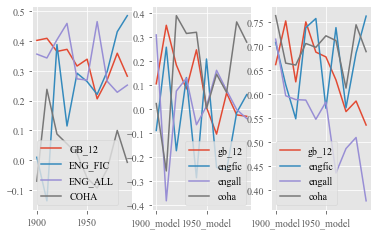

In [26]:
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(nrows=1,ncols=3, figsize = (6.062958350629584, 3.747114333064086))
plt.style.use("ggplot")
for i,corr in enumerate(["affluence_survey_corr","race_survey_corr","gender_survey_corr"]):
    agg_dfs[corr].plot(ax=ax[i])
    plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/survey_corrs.jpg", dpi=400, bbox_inches = "tight")

In [77]:

for i,corr in enumerate(["affluence_survey_corr","race_survey_corr","gender_survey_corr"]):
    d = pd.DataFrame(agg_dfs[corr])
    d.index = [1900+10*j for j in range(10)]
    d.columns = ['GB_12', 'ENG_FIC', 'ENG_ALL', 'COHA']
    d = d[['GB_12', 'ENG_FIC', 'ENG_ALL']]
    if i == 0:
        df = d
    else:
        
        df = df.join(d, rsuffix="t")
print(df.to_latex())

\begin{tabular}{llllllllll}
\toprule
{} &  GB\_12 & ENG\_FIC & ENG\_ALL & GB\_12t & ENG\_FICt & ENG\_ALLt & GB\_12t & ENG\_FICt & ENG\_ALLt \\
\midrule
1900 &  0.402 &    0.01 &   0.356 &  0.105 &   -0.089 &    0.308 &  0.661 &    0.707 &    0.714 \\
1910 &  0.409 &  -0.136 &   0.343 &  0.348 &    0.257 &   -0.381 &  0.752 &    0.619 &    0.596 \\
1920 &  0.365 &   0.388 &   0.404 &  0.183 &   -0.173 &    0.075 &  0.625 &    0.548 &    0.588 \\
1930 &  0.372 &   0.115 &   0.459 &  0.084 &    0.131 &    0.128 &   0.75 &    0.738 &    0.587 \\
1940 &  0.316 &   0.292 &   0.273 &  0.246 &   -0.285 &   -0.065 &  0.687 &    0.757 &    0.547 \\
1950 &  0.339 &   0.264 &   0.269 &  0.007 &    0.208 &    0.012 &  0.677 &     0.57 &    0.583 \\
1960 &  0.206 &   0.221 &   0.465 & -0.104 &   -0.242 &    0.161 &  0.629 &    0.738 &    0.435 \\
1970 &   0.27 &   0.298 &   0.265 &  0.067 &   -0.253 &    0.078 &  0.563 &    0.571 &    0.486 \\
1980 &  0.359 &   0.431 &   0.228 & -0.024 &   -0.015 & 

In [64]:
 pd.DataFrame({"k":d},index = [""])

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [50]:
evals = {}
evals["gb_12"] = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_gb_12_new.csv",header=0, index_col = 0).round(3).T
evals["engfic"] = pd.read_csv("G:/My Drive/KU/Thesis//outputs/evals/evals_histwords_engfic.csv",header=0, index_col = 0).round(3).T
evals["engall"] = pd.read_csv("G:/My Drive/KU/Thesis//outputs/evals/evals_histwords_engall.csv",header=0, index_col = 0).round(3).T
evals["coha"] = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_histwords_coha.csv",header=0, index_col = 0).round(3)
df = evals["coha"].set_index("Unnamed: 0.1")
external_evals = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_external_models.csv",header=0, index_col = 0).round(3).T
#external_evals = external_evals.loc["word2vec-google-news-300"]
external_evals
n = []
#print(df)
a = []
for mod, df in evals.items():
    print(df.columns)
    try:
        df.columns = ['analogy_score', 'word_pair_pearson', 'word_pair_pearson_p_value',
       'word_pair_spearman', 'word_pair_spearman_p_value', 'race_survey_corr',
       'gender_survey_corr', 'affluence_survey_corr']
    except:
        df = df.set_index("Unnamed: 0.1").T
        print(df.index)
        pass
    n.append(df.loc["1990_model", ["word_pair_pearson", "word_pair_pearson_p_value"]])
    a.append(df.loc["1990_model", ["analogy_score"]])
n.append(external_evals.loc["word2vec-google-news-300", ["word_pair_pearson", "word_pair_pearson_p_value"]])
a.append(external_evals.loc["word2vec-google-news-300",["analogy_score"]])
df = pd.concat(n, axis = 1)
df.columns = ['GB_12', 'ENG_FIC', 'ENG_ALL', 'COHA', 'Google News']
df.index = ["Pearson's r", "P-value"]

adf = pd.concat(a, axis = 1)
adf.columns = ['GB_12', 'ENG_FIC', 'ENG_ALL', 'COHA', 'Google News']
adf.index = ["Analogy score"]
print(adf.to_latex())
external_evals

Index(['analogy_score', 'word_pair_pearson', 'word_pair_pearson_p_value',
       'word_pair_spearman', 'word_pair_spearman_p_value', 'race_survey_corr',
       'gender_survey_corr', 'affluence_survey_corr'],
      dtype='object')
Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')
Index(['analogy_score', 'word_pair_pearson', 'word_pair_pearson_p_value',
       'word_pair_spearman', 'word_pair_spearman_p_value', 'race_survey_corr',
       'gender_survey_corr', 'affluence_survey_corr'],
      dtype='object')
Index(['Unnamed: 0.1', '1900_model', '1910_model', '1920_model', '1930_model',
       '1940_model', '1950_model', '1960_model', '1970_model', '1980_model',
       '1990_model'],
      dtype='object')
Index(['1900_model', '1910_model', '1920_model', '1930_model', '1940_model',
       '1950_model', '1960_model', '1970_model', '1980_model', '1990_model'],
      dtype='object')
\begin{tabular}{lrlrrr}
\toprule
{} &  GB\_12 & ENG\_FIC &  ENG\_ALL &   COHA &  Google News \\
\midrule
Analog

,analogy_score,word_pair_pearson,word_pair_pearson_p_value,word_pair_spearman,word_pair_spearman_p_value,race_survey_corr,gender_survey_corr,affluence_survey_corr
fasttext-wiki-news-subwords-300,0.883,0.606,0.0,0.596,0.0,-0.555,0.882,0.491
glove-twitter-100,0.463,0.522,0.0,0.513,0.0,-0.346,0.766,0.144
glove-twitter-200,0.567,0.527,0.0,0.521,0.0,-0.319,0.833,0.299
glove-twitter-25,0.129,0.364,0.0,0.365,0.0,-0.090,0.403,0.042
glove-twitter-50,0.293,0.469,0.0,0.460,0.0,-0.226,0.620,0.059
glove-wiki-gigaword-100,0.633,0.548,0.0,0.533,0.0,-0.103,0.795,0.276
glove-wiki-gigaword-200,0.700,0.578,0.0,0.578,0.0,-0.376,0.875,0.522
glove-wiki-gigaword-300,0.720,0.604,0.0,0.609,0.0,-0.426,0.861,0.549
glove-wiki-gigaword-50,0.464,0.507,0.0,0.503,0.0,-0.044,0.727,0.384
word2vec-google-news-300,0.740,0.624,0.0,0.659,0.0,-0.520,0.804,0.491


In [21]:
df

,0,1,2,3,4,5,6,7
Unnamed: 0.1,analogy_score,word_pair_pearson,word_pair_pearson_p_value,word_pair_spearman,word_pair_spearman_p_value,race_survey_corr,gender_survey_corr,class_survey_corr
1900_model,0.128,0.253,0.0,0.148,0.006,-0.089,0.707,0.01
1910_model,0.11,0.24,0.0,0.114,0.037,0.257,0.619,-0.136
1920_model,0.132,0.28,0.0,0.17,0.002,-0.173,0.548,0.388
1930_model,0.12,0.268,0.0,0.186,0.001,0.131,0.738,0.115
1940_model,0.13,0.284,0.0,0.233,0.0,-0.285,0.757,0.292
1950_model,0.163,0.325,0.0,0.261,0.0,0.208,0.57,0.264
1960_model,0.185,0.352,0.0,0.283,0.0,-0.242,0.738,0.221
1970_model,0.196,0.4,0.0,0.338,0.0,-0.253,0.571,0.298
1980_model,0.212,0.419,0.0,0.387,0.0,-0.015,0.685,0.431


In [54]:
aff = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/affluence_antonyms_goc.csv", 
            header = 0,index_col = "index")#.set_index("rich")
cult = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/cultivation_antonyms_goc.csv", 
            header = 0,index_col = "index")#.set_index("Refined")
soc = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/status_antonyms_goc.csv", 
            header = 0,names =("index", "High status", "Low status"), index_col = "index")#.set_index("High status")
edu = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/education_antonyms_goc.csv",header = 0,index_col = "index")#.set_index("Educated")
rac = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/race_antonyms_goc.csv",header = 0,index_col = "index")
emp = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/employer_antonyms_goc.csv",header = 0,index_col = "index")
gen = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/gender_antonyms_goc.csv",header = 0,index_col = "index")
mor = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/morality_antonyms_goc.csv",header = 0,index_col = "index")
print(pd.concat([gen, mor, emp, rac], axis=1 ).fillna("").set_index("man").to_latex())

\begin{tabular}{llllllll}
\toprule
{} &     woman &            Good &            Bad &        employer &     employee &      white &    black \\
man       &           &                 &                &                 &              &            &          \\
\midrule
men       &     women &                 &                &        employer &     employee &     whites &   blacks \\
he        &       she &                 &                &       employers &    employees &  caucasian &  African \\
him       &       her &            good &           evil &           owner &       worker &   European &  African \\
his       &       her &          honest &      dishonest &          owners &      workers &      Anglo &     Afro \\
his       &      hers &            good &            bad &   industrialist &      laborer &      White &    Black \\
boy       &      girl &        virtuous &         sinful &  industrialists &     laborers &     Whites &   Blacks \\
boys      &     girls &    

In [85]:
df = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/variance_unweighted.csv", sep = " ")
df.columns = [" "]
a = []
for row in df.iterrows():
    a.append([float(g) for g in row[1][" "].split(",")[1:]])
a = np.array(a)
np.mean(a, axis = 0)

array([284.03793821, 314.43848388, 313.26447081])

In [55]:
!pip install nbconvert

The current directory is invalid.
